<div style="text-align: center;">
    <h1>Sentimental Analysis</h1>
</div>

**Submitted By:** _Sariga M S_<br>
**Date:** _October 2023_

In [1]:
!conda activate myenv

In [2]:
# !pip install transformers

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import re
import tensorflow
import keras
from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,Conv1D, GlobalMaxPooling1D, Dense
from matplotlib import rc
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [2]:
df = pd.read_csv(r'C:\Users\Dell\Downloads\IMDB Dataset.csv')
df.shape

(14999, 2)

In [5]:
# Let's have a look at the data 
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Let's check for missing values 
df.isnull().sum()

review       0
sentiment    0
dtype: int64

**There are no missing values**

**Visualising distribution of sentiment and see if the data is imbalanced.**

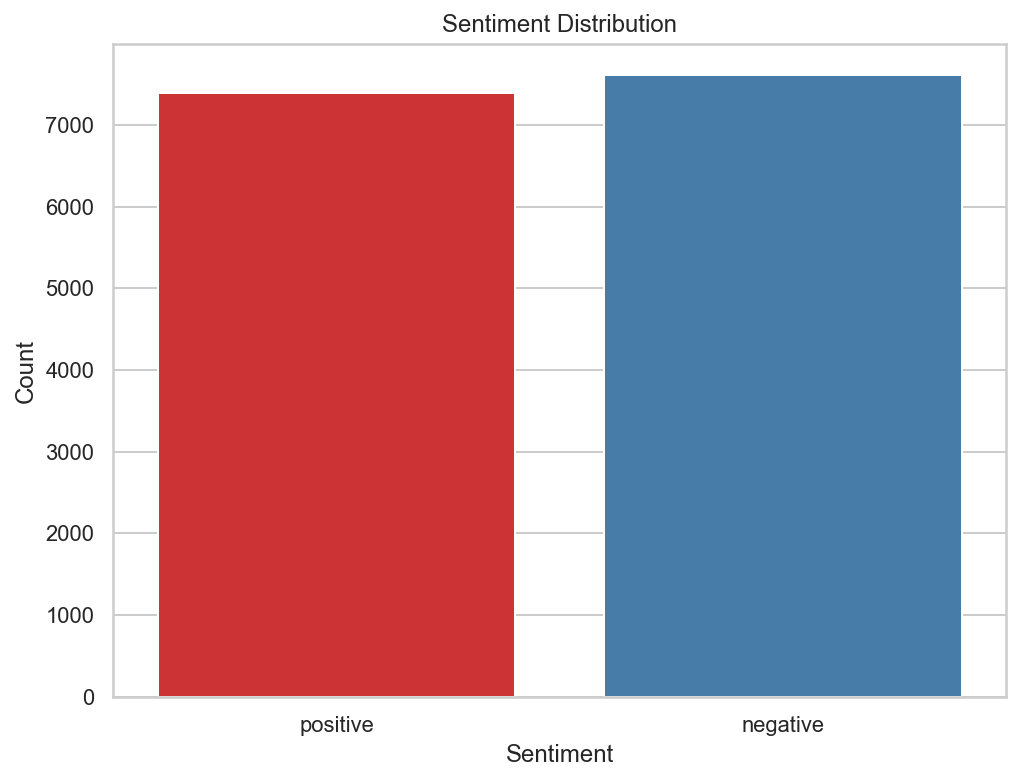

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='Set1')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Show the plot
plt.show()

The data is balanced

## Data Preprocessing

Removing punctuation, special characters and converting text into lower case

In [3]:
def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing function to the 'review' column
df['review'] = df['review'].apply(preprocess_text)
print(df['review'])

0        one of the other reviewers has mentioned that ...
1        a wonderful little production br br the filmin...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
14994     out of br br yep dressed to kill is that kind...
14995    bobcat goldthwait should be commended for atte...
14996    and its not because since her days on clarissa...
14997    a traveling couple horton and hamiltonstumble ...
14998    this film is deeply disappointing not only tha...
Name: review, Length: 14999, dtype: object


### Removing stopwords

In [4]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

df['review'] = df['review'].apply(lambda text: ' '.join(remove_stopwords(text.split())))
print(df['review'])

0        one reviewers mentioned watching oz episode yo...
1        wonderful little production br br filming tech...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
14994    br br yep dressed kill kind movie like kalifor...
14995    bobcat goldthwait commended attempting somethi...
14996    since days clarissa explains ive bit crush mel...
14997    traveling couple horton hamiltonstumble onto t...
14998    film deeply disappointing wenders displays lim...
Name: review, Length: 14999, dtype: object


### Lemmatization

In [5]:
def apply_lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


df['review'] = df['review'].apply(lambda text: ' '.join(apply_lemmatization(text.split())))
print(df['review'])

0        one reviewer mentioned watching oz episode you...
1        wonderful little production br br filming tech...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
14994    br br yep dressed kill kind movie like kalifor...
14995    bobcat goldthwait commended attempting somethi...
14996    since day clarissa explains ive bit crush meli...
14997    traveling couple horton hamiltonstumble onto t...
14998    film deeply disappointing wenders display limi...
Name: review, Length: 14999, dtype: object


We use the LabelEncoder()  to convert the labels ‘positive’, ‘negative’ into 1’s and 0’s respectively.


In [6]:
reviews = df['review'].values
labels = df['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

Splitting the dataset for training and testing - Let's use 80% of the dataset for training and 20% for testing.

In [7]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [8]:
# Hyperparameters of the model
vocab_size = 3000 
oov_tok = ''
embedding_dim = 100
max_length = 200 
padding_type='post'
trunc_type='post'

In [9]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [10]:
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# RNN

**Recurrent Neural Networks (RNNs) are a class of deep learning models ideally suited for sentiment analysis tasks. In the context of sentiment analysis, RNNs excel in capturing the contextual and sequential nature of language, allowing them to understand the dependencies and nuances in text data. Their ability to consider the order of words and their recurrent connections make them capable of identifying sentiment shifts in sentences, making them valuable tools for distinguishing between positive and negative sentiments in textual content.**

In [21]:
# Create the RNN model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Add a SimpleRNN layer with a specified number of units (adjust as needed)
model.add(SimpleRNN(128, activation='tanh', return_sequences=False))

# Add a Dense layer with one output unit (for binary sentiment classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model using your training data
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(test_padded, test_labels))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          300000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 329,441
Trainable params: 329,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
352/352 [==============================] - 19s 51ms/step - loss: 0.7003 - accuracy: 0.5016 - val_loss: 0.6954 - val_accuracy: 0.5037
Epoch 2/20
352/352 [==============================] - 19s 55ms/step - loss: 0.6990 - accuracy: 0.5064 - val_loss: 0.6957 - val_accuracy: 0.4963
Epoch 3/20
352/352 [====

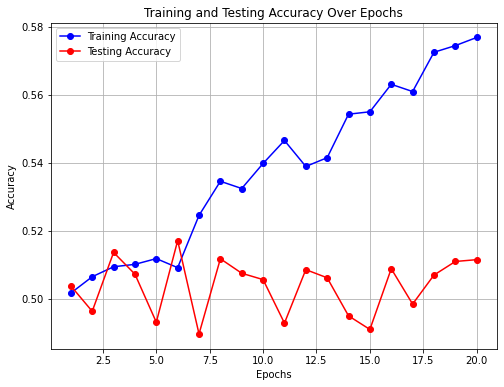

In [22]:
# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, 21), test_accuracy, label='Testing Accuracy', marker='o', linestyle='-', color='r')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()

In [23]:
# reviews on which we need to predict
sentences = ["I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied",
            "This movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling",
            "Good acting. Plot is terrible"]

# Tokenize and pad the sequences for prediction
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Predict sentiment labels
predictions = model.predict(padded)
pred_labels = [1 if pred >= 0.5 else 0 for pred in predictions]

# Map sentiment labels to 'Positive' or 'Negative'
sentiment_labels = ['Negative', 'Positive']

for i in range(len(sentences)):
    print(sentences[i])
    predicted_sentiment = sentiment_labels[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)


1/1 [==============================] - 1s 604ms/step
I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied
Predicted sentiment:  Positive
This movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling
Predicted sentiment:  Negative
Good acting. Plot is terrible
Predicted sentiment:  Negative


# LSTM

**Long Short-Term Memory (LSTM) is a recurrent neural network architecture that excels in capturing and understanding sequential patterns in textual data. In sentiment analysis, LSTM models are widely used due to their ability to retain information over long sequences, making them well-suited for analyzing sentiment-related nuances in text. LSTMs can effectively learn dependencies and contextual information in sentences, allowing them to distinguish between positive, negative, and neutral sentiments in natural language text.**

### Model building using LSTM

In [11]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 5
history = model.fit(train_padded, train_labels,epochs=num_epochs, verbose=1,validation_split=0.1)

Epoch 1/5
317/317 [==============================] - 72s 212ms/step - loss: 0.4941 - accuracy: 0.7582 - val_loss: 0.3683 - val_accuracy: 0.8329
Epoch 2/5
317/317 [==============================] - 62s 196ms/step - loss: 0.3074 - accuracy: 0.8816 - val_loss: 0.3588 - val_accuracy: 0.8462
Epoch 3/5
317/317 [==============================] - 56s 177ms/step - loss: 0.2449 - accuracy: 0.9077 - val_loss: 0.3373 - val_accuracy: 0.8560
Epoch 4/5
317/317 [==============================] - 54s 170ms/step - loss: 0.1886 - accuracy: 0.9304 - val_loss: 0.3762 - val_accuracy: 0.8338
Epoch 5/5
317/317 [==============================] - 49s 155ms/step - loss: 0.1530 - accuracy: 0.9451 - val_loss: 0.3848 - val_accuracy: 0.8578


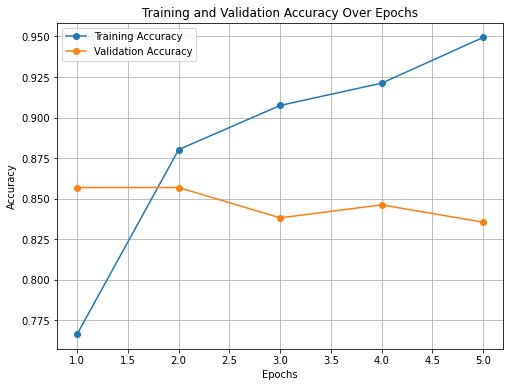

In [38]:
# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()

In [27]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

118/118 [==============================] - 6s 40ms/step
Accuracy of prediction on test set :  0.8448


In [ ]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

In [28]:
# reviews on which we need to predict
sentence = ["I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied", 
            "this movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling", 
            "Good acting. Plot is terrible"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 237ms/step
I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied
Predicted sentiment :  Negative
this movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling
Predicted sentiment :  Positive
Good acting. Plot is terrible
Predicted sentiment :  Negative


# CNN

**Convolutional Neural Networks (CNNs) have shown promise in sentiment analysis tasks by leveraging their ability to capture local and global features within text data. In the context of sentiment analysis, CNNs use convolutional layers to detect meaningful patterns and features, such as sentiment-related phrases or expressions, making them effective at identifying sentiment cues in text. Their flexibility in learning hierarchical representations from sequences of words allows CNNs to automatically extract relevant features, contributing to their success in sentiment classification tasks.**

In [41]:
# Create the CNN model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Add a 1D convolutional layer
model.add(Conv1D(128, 5, activation='relu'))

# Add a global max-pooling layer
model.add(GlobalMaxPooling1D())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))

# Add the output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model using your training data
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 100)          300000    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 380,769
Trainable params: 380,769
Non-trainable params: 0
________________________________________________

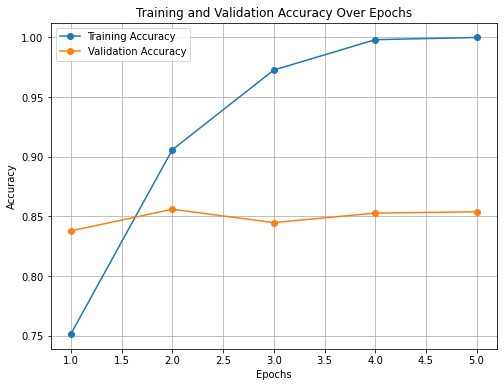

In [42]:
# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()

In [43]:
# Reviews on which we need to predict
sentences = [
    "I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied",
    "This movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling",
    "Good acting. Plot is terrible"
]

# Tokenize and pad the sequences for prediction
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Predict sentiment labels
predictions = model.predict(padded)
pred_labels = [1 if pred >= 0.5 else 0 for pred in predictions]

# Map sentiment labels to 'Positive' or 'Negative'
sentiment_labels = ['Negative', 'Positive']

for i in range(len(sentences)):
    print(sentences[i])
    predicted_sentiment = sentiment_labels[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)

1/1 [==============================] - 0s 164ms/step
I found the film to be quite disappointing. The plot was confusing, and the acting was subpar, leaving me unsatisfied
Predicted sentiment:  Negative
This movie was absolutely fantastic! The acting and storyline were top-notch, and I couldn't stop smiling
Predicted sentiment:  Positive
Good acting. Plot is terrible
Predicted sentiment:  Negative


# BERT

### Data Preprocessing for BERT

**BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art natural language processing model based on the transformer architecture. It is pre-trained on a large corpus of text data and has the ability to understand contextual information in both directions (left-to-right and right-to-left), making it highly effective for various NLP tasks.**

In [44]:
import tensorflow as tf
import sklearn
from tqdm import tqdm

In [45]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
X = df[['review','sentiment']]

In [47]:
# changing positive and negative into numeric values
def numerical(value):
    if value=='positive': 
        return 1
    else: 
        return 0
    
X['sentiment']  =  X['sentiment'].apply(numerical)
train = X[:12000]
test = X[12000:]

In [48]:
def convert_data_to_examples(train, test, review, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'review',  'sentiment')

In [49]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    
            max_length=max_length,    
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, 
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'

In [50]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(64).repeat(2)

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:00<00:00, 197.41it/s]


In [51]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(64)

100%|█████████████████████████████████████████████████████████████████████████████| 2999/2999 [00:13<00:00, 226.53it/s]


In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, epsilon=1e-10, clipnorm=2.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=1, validation_data=validation_data)

ResourceExhaustedError: Graph execution error:

Detected at node 'tf_bert_for_sequence_classification/bert/encoder/layer_._1/attention/self/truediv' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
      ret = callback()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
      self.run()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2877, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2923, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3146, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-52-24a5b095e3b8>", line 5, in <module>
      model.fit(train_data, epochs=1, validation_data=validation_data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1638, in train_step
      y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs
      "The old compute_loss method is deprecated as it conflicts with the Keras compute_loss "
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1569, in call
      outputs = self.bert(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs
      "The old compute_loss method is deprecated as it conflicts with the Keras compute_loss "
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 862, in call
      encoder_outputs = self.encoder(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 548, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 554, in call
      layer_outputs = layer_module(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 464, in call
      self_attention_outputs = self.attention(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 380, in call
      self_outputs = self.self_attention(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 312, in call
      attention_scores = tf.divide(attention_scores, dk)
Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._1/attention/self/truediv'
OOM when allocating tensor with shape[64,12,128,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node tf_bert_for_sequence_classification/bert/encoder/layer_._1/attention/self/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_157718]

**CNN model appears to be the most promising, given its high accuracy and reasonable generalization. But it is prone to overfitting. For Streamlit app, let's take LSTM model. RNN model has lower accuracy on both training and validation data.**

In [14]:
import pickle

#For model
pickle.dump(model,open('lstm_model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://41fb16a1-4998-4295-af33-e1a3856fe684/assets


INFO:tensorflow:Assets written to: ram://41fb16a1-4998-4295-af33-e1a3856fe684/assets


In [15]:
model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


In [17]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)